Nama : Agung Rizky S

Kelas : TI-3C

Nim : 2241720187

Github : https://github.com/agungrizkysetiawan/PembelajaranMesin.git

# JOBSHEET 10

# Praktikum 1
RNN untuk Analisis Sentimen

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [7]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
     plt.plot(history.history[metric])
     plt.plot(history.history['val_'+metric], '')
     plt.xlabel("Epochs")
     plt.ylabel(metric)
     plt.legend([metric, 'val_'+metric])

# Setup input pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.


In [27]:

dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [28]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [29]:

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"So-so thriller starring Brad Pitt and Juliette Lewis, who join David Duchovny and Michelle Forbes on a road trip out west. The latter couple are researching notorious murder sites for an upcoming book; Pitt's a serial killer on the lam (unbeknownst to Dave) and Juliette is his poor, not-all-there companion. This is a good cast and the story moves along, but Pitt isn't belivably scary as a serial killer, although it is one of his better earlier roles. The best thing is here is Michelle Forbes, who always manages to shine, whether in her roles on `Homicide: Life on the Street' or in the brief series `Wonderland.'<br /><br />Vote: 6"
 b'This is a film which had eluded me thus far but, now that I\'ve watched it, emerges as one of the major entries in the noir style. As usual with the DivX format, the viewing was far from ideal \xc2\x96 marred by the occasional video and (mostly) audio glitches \xc2\x96 but, given that the film is still unavailable on R1 DVD, this will have to do

# Buat Teks Encoder

In [30]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [31]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [32]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  1, 773,   1, ...,   0,   0,   0],
       [ 11,   7,   4, ...,   0,   0,   0],
       [  1,   1,   2, ...,   0,   0,   0]])

In [33]:

for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"So-so thriller starring Brad Pitt and Juliette Lewis, who join David Duchovny and Michelle Forbes on a road trip out west. The latter couple are researching notorious murder sites for an upcoming book; Pitt's a serial killer on the lam (unbeknownst to Dave) and Juliette is his poor, not-all-there companion. This is a good cast and the story moves along, but Pitt isn't belivably scary as a serial killer, although it is one of his better earlier roles. The best thing is here is Michelle Forbes, who always manages to shine, whether in her roles on `Homicide: Life on the Street' or in the brief series `Wonderland.'<br /><br />Vote: 6"
Round-trip:  [UNK] thriller [UNK] [UNK] [UNK] and [UNK] [UNK] who [UNK] david [UNK] and [UNK] [UNK] on a [UNK] [UNK] out [UNK] the [UNK] couple are [UNK] [UNK] murder [UNK] for an [UNK] book [UNK] a [UNK] killer on the [UNK] [UNK] to [UNK] and [UNK] is his poor [UNK] [UNK] this is a good cast and the story [UNK] along but [UNK] isnt [UNK] scary a

# Buat Model

In [34]:

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [35]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [36]:
import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(text):
    return tf.data.Dataset.from_tensor_slices([text]).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
dataset = create_dataset(sample_text)

# Prediksi menggunakan model
predictions = model.predict(dataset)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.02689573]


In [37]:

import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(texts):
    return tf.data.Dataset.from_tensor_slices(texts).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
padding = "the " * 2000  # Padding text
texts = [sample_text, padding]  # List of texts including padding

# Membuat dataset dari teks
dataset = create_dataset(texts)

# Prediksi menggunakan model
predictions = model.predict(dataset)
for pred in predictions:
    print(pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
[0.02689573]
[0.03421294]


In [38]:

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train Model

In [39]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 784s 2s/step - accuracy: 0.5252 - loss: 0.6746 - val_accuracy: 0.7625 - val_loss: 0.4402
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 769s 2s/step - accuracy: 0.8174 - loss: 0.3973 - val_accuracy: 0.8474 - val_loss: 0.3347
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - accuracy: 0.8493 - loss: 0.3468 - val_accuracy: 0.8672 - val_loss: 0.3088
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 795s 2s/step - accuracy: 0.8547 - loss: 0.3276 - val_accuracy: 0.8510 - val_loss: 0.3368
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 763s 2s/step - accuracy: 0.8636 - loss: 0.3150 - val_accuracy: 0.8620 - val_loss: 0.3193
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 792s 2s/step - accuracy: 0.8661 - loss: 0.3092 - val_accuracy: 0.8490 - val_loss: 0.3288
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 822s 2s/step - accuracy: 0.8656 - loss: 0.3111 - val_accuracy: 0.8526 - val_loss: 0.3087
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 798s 2s/step - accuracy: 0.8712 - loss: 0.3016 - val_accu

In [40]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 184s 470ms/step - accuracy: 0.8483 - loss: 0.3215
Test Loss: 0.3214717507362366
Test Accuracy: 0.8476399779319763


(0.0, 0.6262600675225258)

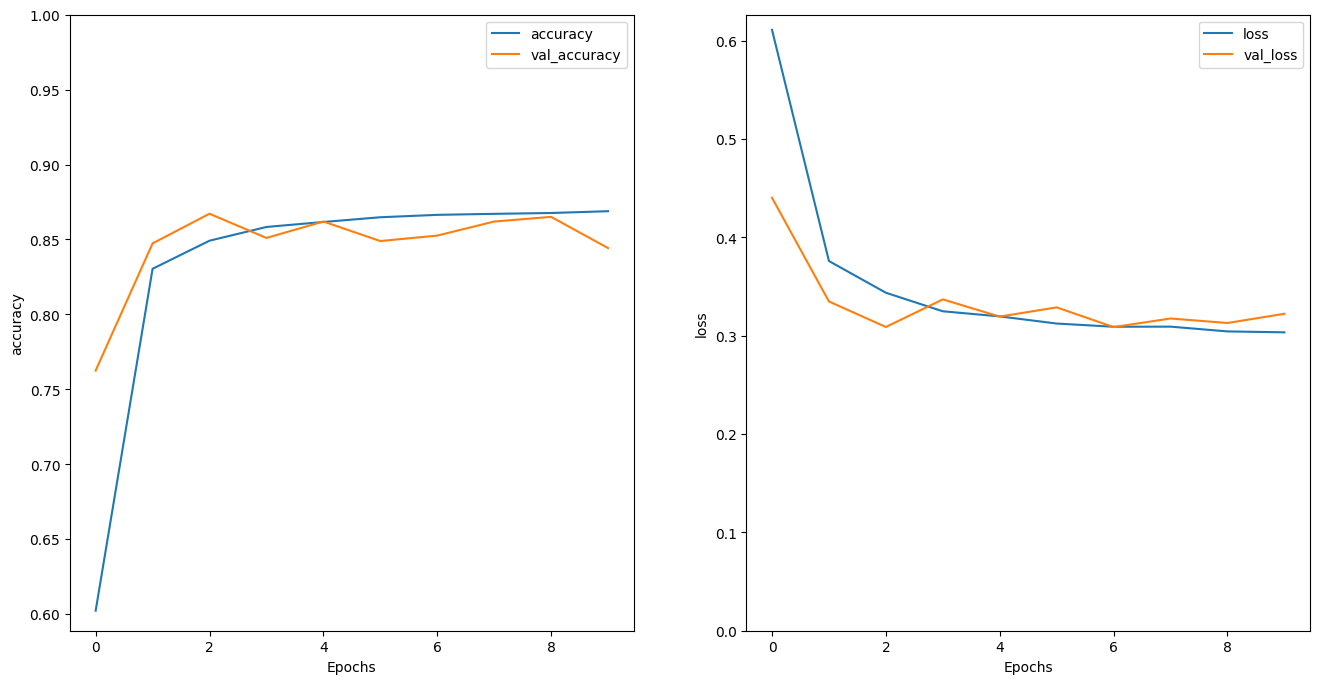

In [41]:

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [42]:
import numpy as np
import tensorflow as tf

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Mengonversi teks menjadi tensor
sample_tensor = tf.convert_to_tensor([sample_text])

# Prediksi menggunakan model
predictions = model.predict(sample_tensor)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
[0.6832535]



# Stack two or more LSTM layers

In [43]:

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [44]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [45]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1598s 4s/step - accuracy: 0.5141 - loss: 0.6806 - val_accuracy: 0.8109 - val_loss: 0.4133
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1483s 4s/step - accuracy: 0.8189 - loss: 0.4078 - val_accuracy: 0.8547 - val_loss: 0.3379
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1458s 4s/step - accuracy: 0.8493 - loss: 0.3475 - val_accuracy: 0.8745 - val_loss: 0.3015
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1441s 4s/step - accuracy: 0.8632 - loss: 0.3222 - val_accuracy: 0.8562 - val_loss: 0.3299
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1472s 4s/step - accuracy: 0.8654 - loss: 0.3184 - val_accuracy: 0.8583 - val_loss: 0.3233
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1470s 4s/step - accuracy: 0.8686 - loss: 0.3114 - val_accuracy: 0.8620 - val_loss: 0.3181
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1459s 4s/step - accuracy: 0.8678 - loss: 0.3049 - val_accuracy: 0.8661 - val_loss: 0.3073
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1458s 4s/step - accuracy: 0.8681 - loss: 0.3060 - 

In [46]:

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 291s 745ms/step - accuracy: 0.8642 - loss: 0.3430
Test Loss: 0.3408074676990509
Test Accuracy: 0.8626800179481506


In [47]:

import numpy as np
import tensorflow as tf

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')

# Mengonversi teks menjadi tensor
sample_tensor = tf.convert_to_tensor([sample_text])

# Prediksi menggunakan model
predictions = model.predict(sample_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[-1.9176033]]


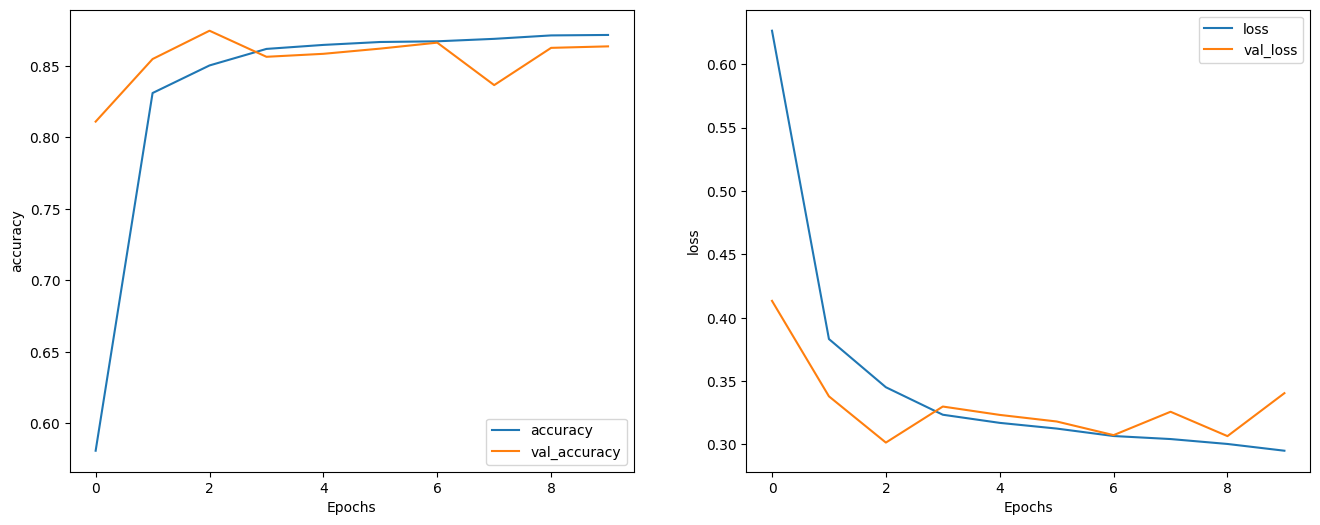

In [48]:

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')


# Praktikum 2 Generator Teks dengan RNN
setup

In [49]:

import tensorflow as tf
import numpy as np
import os
import time

In [50]:

path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step



# Load Data

In [51]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [52]:

# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [53]:

# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


# Olah Teks

### Vectorize Teks

In [54]:

example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [55]:

ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [56]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [57]:

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [58]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [59]:

tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [60]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

# Prediksi
Membuat Trianing Set dan Target

In [61]:

all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [62]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [63]:

for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [64]:

seq_length = 100

In [65]:

sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [66]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [67]:

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [68]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [69]:
dataset = sequences.map(split_input_target)


In [70]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


# Membuat Batch Training

In [71]:

# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# Buat Model


# Buat Model

In [72]:

# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [113]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    # Remove 'self' from super().__init__() call
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [114]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)


# Tugas

Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan. Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan.

Gunakan tf.GradientTape untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca eager execution guide.

Prosedurnya adalah :

1. Jalankan Model dan hitung loss dengan tf GradientTape.
2. Hitung update dan terapkan pada model dengan optimizer

In [147]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [148]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [149]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))


In [ ]:
model.fit(dataset, epochs=1)

In [158]:
import tensorflow as tf
import time


EPOCHS = 10

# Instead of using tf.metrics.Mean, use a simple variable to store the running sum and count
total_loss = 0.0
num_batches = 0

for epoch in range(EPOCHS):
  start = time.time()

  # Reset the running sum and count at the beginning of each epoch
  total_loss = 0.0
  num_batches = 0
  for (batch_n, (inp, target)) in enumerate(dataset):
    logs = model.train_step([inp, target])

    # Check if logs is not None and has the 'loss' key
    if logs is not None and 'loss' in logs:
      total_loss += logs['loss']  # Accumulate the loss
    else:
      print(f"Warning: train_step did not return expected logs for batch {batch_n} in epoch {epoch + 1}. logs: {logs}")

    num_batches += 1  # Increment the batch count

    if batch_n % 50 == 0:
      # Handle the case where logs might be None or missing 'loss'
      # Check if 'loss' is in logs and it's a number before formatting
      if logs is not None and 'loss' in logs and isinstance(logs['loss'], (int, float)):
        loss_value = logs['loss']
        template = f"Epoch {epoch+1} Batch {batch_n} Loss {loss_value:.4f}"
      else:
        template = f"Epoch {epoch+1} Batch {batch_n} Loss N/A" # Use a separate template for non-numeric loss
      print(template)

  # Calculate the mean loss for the epoch
  mean_loss = total_loss / num_batches if num_batches > 0 else 0.0

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print()
  print(f'Epoch {epoch+1} Loss: {mean_loss:.4f}')  # Print the calculated mean loss
  print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
  print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss N/A
Epoch 1 Batch 50 Loss N/A
Epoch 1 Batch 100 Loss N/A
Epoch 1 Batch 150 Loss N/A

Epoch 1 Loss: 0.0000
Time taken for 1 epoch 4.14 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss N/A
Epoch 2 Batch 50 Loss N/A
Epoch 2 Batch 100 Loss N/A
Epoch 2 Batch 150 Loss N/A

Epoch 2 Loss: 0.0000
Time taken for 1 epoch 3.52 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss N/A
Epoch 3 Batch 50 Loss N/A
Epoch 3 Batch 100 Loss N/A
Epoch 3 Batch 150 Loss N/A

Epoch 3 Loss: 0.0000
Time taken for 1 epoch 3.39 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss N/A
Epoch 4 Batch 50 Loss N/A
Epoch 4 Batch 100 Loss N/A
Epoch 4 Batch 150 Loss N/A

Epoch 4 Loss: 0.0000
Time taken for 1 epoch 5.41 sec
________________________________________________________________________________
Epoch 5 Batch 0 Loss N/A
Epoch 5 Batch 5

NameError: name 'checkpoint_prefix' is not defined

# Jawab:

Pada praktikum kedua, penggunaan metode train_step memang cenderung lebih sederhana karena pada dasarnya metode ini hanya menangani satu langkah pelatihan (training step) pada satu batch data.

Pada tugas, menggunakan metode train, proses pelatihan menjadi lebih kompleks namun terstruktur dengan baik. Metode train adalah implementasi tingkat lebih tinggi yang sudah mengabstraksi banyak bagian dari proses pelatihan. Dengan menggunakan metode ini, model secara otomatis mengelola berbagai aspek seperti pengaturan batch size, optimisasi, dan pelacakan langkah-langkah pelatihan.

